In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from PIL import Image
import torchvision.transforms as transforms
import cv2
import os

In [6]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np

class SegmentationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_names = [f for f in os.listdir(root_dir) if f.endswith('_sat.jpg')]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        image_path = os.path.join(self.root_dir, img_name)
        mask_name = img_name.replace('_sat.jpg', '_mask.png')
        mask_path = os.path.join(self.root_dir, mask_name)

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # Binarize the mask
        mask = (mask > 0.5).float()  # Assuming the mask has been converted to a tensor

        return image, mask


In [7]:
import torchvision.transforms as transforms


class HistogramEqualization:
    def __call__(self, img):
        img_array = np.array(img)
        if len(img_array.shape) == 3 and img_array.shape[2] == 3:  # Color image
            img_yuv = cv2.cvtColor(img_array, cv2.COLOR_RGB2YUV)
            img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
            img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
        elif len(img_array.shape) == 2 or img_array.shape[2] == 1:  # Grayscale image
            img_output = cv2.equalizeHist(img_array)
        return Image.fromarray(img_output)

# Example transform to convert images to tensor and apply histogram equalization
transform = transforms.Compose([
    HistogramEqualization(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [8]:
# Creating dataset and dataloader
train_dataset = SegmentationDataset(root_dir='/home/Bounty_hunters/vision_satellite/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)

In [9]:
def visualize_data(images, masks, num_images=2):

    batch_indices = np.random.choice(images.size(0), num_images, replace=False)
    batch_images = images[batch_indices]
    batch_masks = masks[batch_indices]

    # Create a grid of images and masks
    grid_images = make_grid(batch_images, nrow=num_images, normalize=True)
    grid_masks = make_grid(batch_masks, nrow=num_images, normalize=True)

    # Convert the grid images and masks to numpy arrays
    grid_images = grid_images.numpy().transpose(1, 2, 0)
    grid_masks = grid_masks.numpy().transpose(1, 2, 0)

    # Plot the images and masks
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(grid_images)
    plt.title('Images')
    plt.subplot(1, 2, 2)
    plt.imshow(grid_masks)
    plt.title('Masks')
    plt.show()

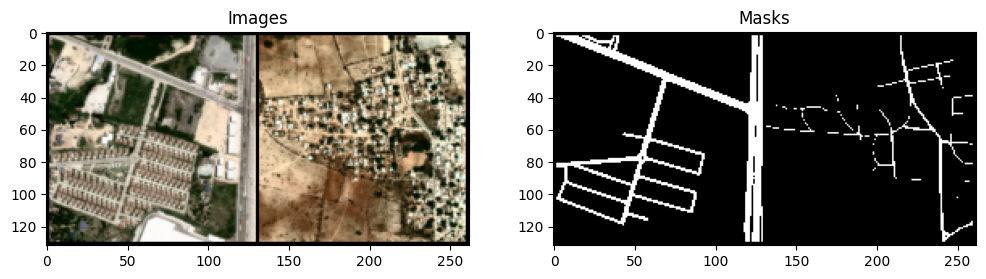

In [10]:
images, masks = next(iter(train_loader))
visualize_data(images, masks)

In [25]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.middle = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, kernel_size=2, stride=2),
            nn.ConvTranspose2d(out_channels, out_channels, kernel_size=2, stride=2)
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.middle(x1)
        #print(x2.shape)
        x3 = self.decoder(x2)
        #print(x3.shape)
        return x3

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(in_channels=3, out_channels=1).to(device)

In [27]:
model.to(device)

UNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (middle): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2))
    (5): ConvTranspose2d(1, 1, kernel_size=(2, 2), strid

In [29]:
lr = 0.001
num_epochs = 10

#loss function with opt
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [16]:
def iou(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    if union == 0:
        return torch.tensor(1.0)  # Perfect match
    return intersection / union

In [28]:
#training loop
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, masks in train_loader:
        inputs = inputs.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

In [30]:
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss))

Epoch [1/10], Loss: 0.1866
Epoch [2/10], Loss: 0.1318
Epoch [3/10], Loss: 0.1233
Epoch [4/10], Loss: 0.1186
Epoch [5/10], Loss: 0.1146
Epoch [6/10], Loss: 0.1116
Epoch [7/10], Loss: 0.1094
Epoch [8/10], Loss: 0.1071
Epoch [9/10], Loss: 0.1047
Epoch [10/10], Loss: 0.1032


In [31]:
torch.save(model.state_dict(), 'unet_model_base.pth')


In [32]:
# Load the trained model
model = UNet(in_channels=3, out_channels=1)  # Replace with appropriate parameters
model.load_state_dict(torch.load('unet_model_base.pth'))
# model.eval()

<All keys matched successfully>

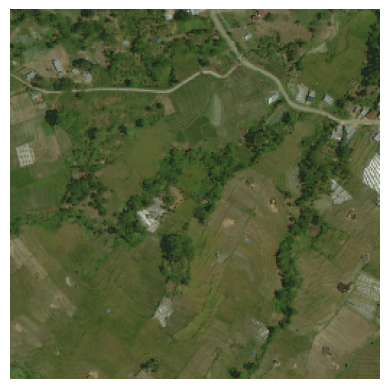

In [33]:
img = cv2.imread('/home/Bounty_hunters/vision_satellite/test/12416_sat.jpg')
# Step 2: Resize the image to (256, 256)
img_resized = cv2.resize(img, (256, 256))

# Step 3: Convert BGR to RGB (OpenCV uses BGR by default)
img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

# Step 4: Display the image using Matplotlib
plt.imshow(img_rgb)
plt.axis('off')  # Hide axis
plt.show()

In [40]:
# Load the sample image from test set
sample_image = Image.open('/home/Bounty_hunters/vision_satellite/test/12416_sat.jpg')
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
sample_image = transform(sample_image).unsqueeze(0)

In [41]:
#  Evaluate the model on the sample image
with torch.no_grad():
    output = model(sample_image)
    predicted_mask = torch.sigmoid(output)

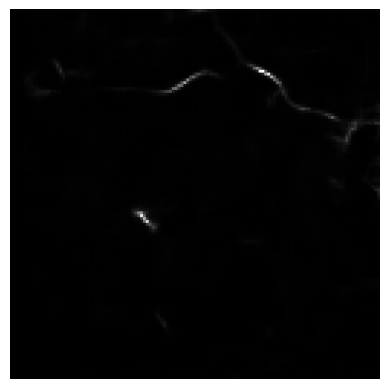

In [42]:
predicted_mask = predicted_mask.squeeze(0).squeeze(0).numpy()
import matplotlib.pyplot as plt
plt.imshow(predicted_mask, cmap='gray')
plt.axis('off')
plt.show()

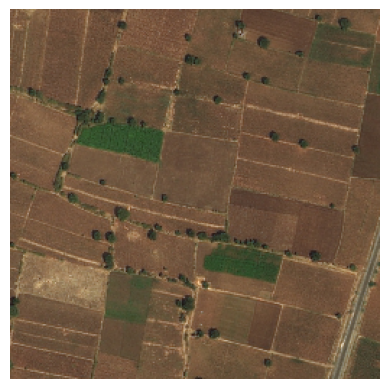

In [43]:
img = cv2.imread('/home/Bounty_hunters/vision_satellite/test/997992_sat.jpg')
# Step 2: Resize the image to (256, 256)
img_resized = cv2.resize(img, (256, 256))

# Step 3: Convert BGR to RGB (OpenCV uses BGR by default)
img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

# Step 4: Display the image using Matplotlib
plt.imshow(img_rgb)
plt.axis('off')  # Hide axis
plt.show()

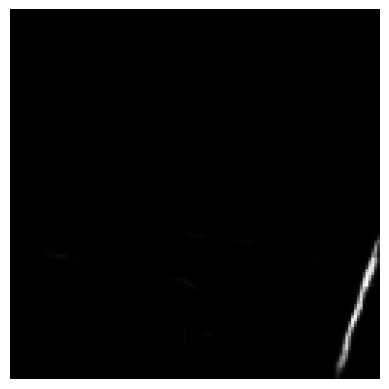

In [45]:
# Load the sample image from test set
sample_image = Image.open('/home/Bounty_hunters/vision_satellite/test/997992_sat.jpg')
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
sample_image = transform(sample_image).unsqueeze(0)

#  Evaluate the model on the sample image
with torch.no_grad():
    output = model(sample_image)
    predicted_mask = torch.sigmoid(output)

predicted_mask = predicted_mask.squeeze(0).squeeze(0).numpy()
import matplotlib.pyplot as plt
plt.imshow(predicted_mask, cmap='gray')
plt.axis('off')
plt.show()

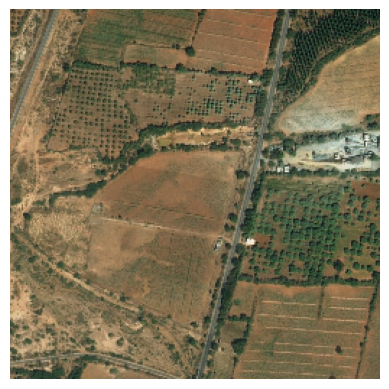

In [46]:
img = cv2.imread('/home/Bounty_hunters/vision_satellite/test/25089_sat.jpg')
# Step 2: Resize the image to (256, 256)
img_resized = cv2.resize(img, (256, 256))

# Step 3: Convert BGR to RGB (OpenCV uses BGR by default)
img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

# Step 4: Display the image using Matplotlib
plt.imshow(img_rgb)
plt.axis('off')  # Hide axis
plt.show()

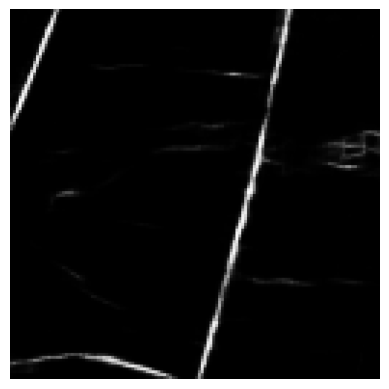

In [47]:
# Load the sample image from test set
sample_image = Image.open('/home/Bounty_hunters/vision_satellite/test/25089_sat.jpg')
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
sample_image = transform(sample_image).unsqueeze(0)

#  Evaluate the model on the sample image
with torch.no_grad():
    output = model(sample_image)
    predicted_mask = torch.sigmoid(output)

predicted_mask = predicted_mask.squeeze(0).squeeze(0).numpy()
import matplotlib.pyplot as plt
plt.imshow(predicted_mask, cmap='gray')
plt.axis('off')
plt.show()

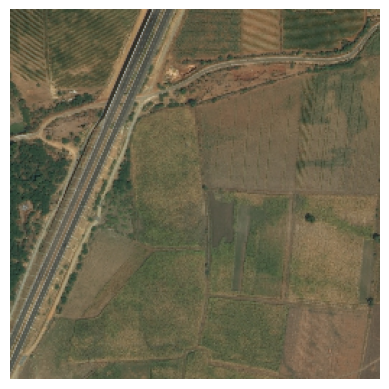

In [50]:
img = cv2.imread('/home/Bounty_hunters/vision_satellite/test/958252_sat.jpg')
# Step 2: Resize the image to (256, 256)
img_resized = cv2.resize(img, (256, 256))

# Step 3: Convert BGR to RGB (OpenCV uses BGR by default)
img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

# Step 4: Display the image using Matplotlib
plt.imshow(img_rgb)
plt.axis('off')  # Hide axis
plt.show()

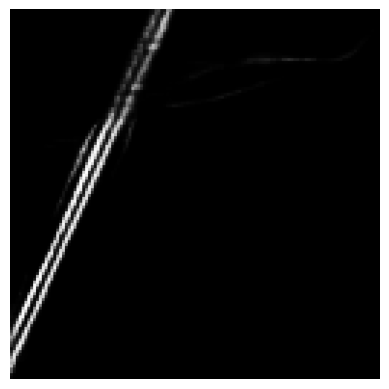

In [51]:
# Load the sample image from test set
sample_image = Image.open('/home/Bounty_hunters/vision_satellite/test/958252_sat.jpg')
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
sample_image = transform(sample_image).unsqueeze(0)

#  Evaluate the model on the sample image
with torch.no_grad():
    output = model(sample_image)
    predicted_mask = torch.sigmoid(output)

predicted_mask = predicted_mask.squeeze(0).squeeze(0).numpy()
import matplotlib.pyplot as plt
plt.imshow(predicted_mask, cmap='gray')
plt.axis('off')
plt.show()